<a href="https://colab.research.google.com/github/Pakapakk/Network_Traffic_Anomaly_Detection/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [34]:
kdd_df = pd.read_csv("hf://datasets/Pakapak/kdd_cup_1999/kdd_df.csv")

In [35]:
kdd_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack_type
0,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


# Preprocessing

In [36]:
kdd_df.isnull().sum()

,0
duration,0
protocol_type,0
service,0
flag,0
src_bytes,0
dst_bytes,0
land,0
wrong_fragment,0
urgent,0
hot,0


In [37]:
Kdd_df = kdd_df.dropna(axis='columns')

In [38]:
# Finding categorical features
num_cols = kdd_df._get_numeric_data().columns

cate_cols = list(set(kdd_df.columns)-set(num_cols))
cate_cols.remove('target')
cate_cols.remove('attack_type')

cate_cols

['flag', 'service', 'protocol_type']

In [39]:
def bar_graph(df, feature):
    df[feature].value_counts().plot(kind="bar")

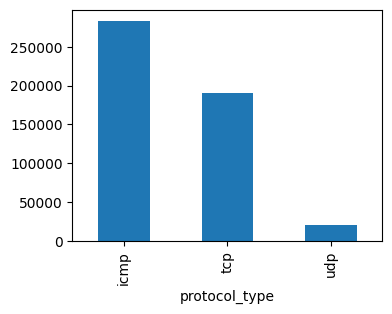

In [40]:
plt.figure(figsize=(4, 3))
bar_graph(kdd_df, 'protocol_type')

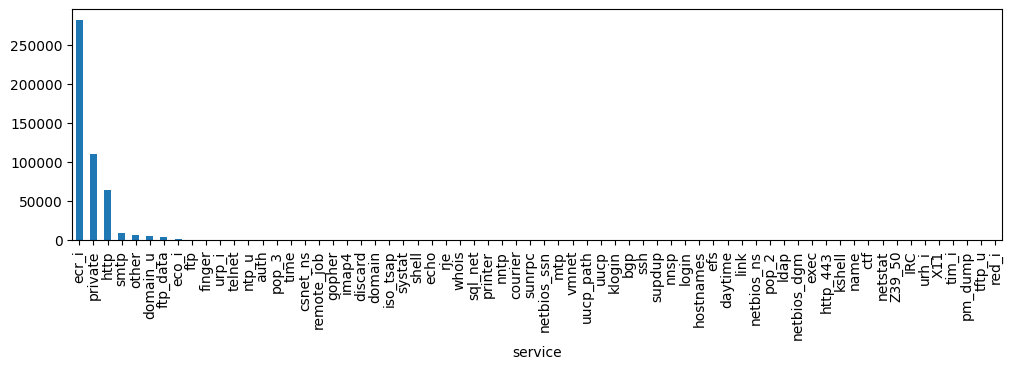

In [41]:
plt.figure(figsize=(12,3))
bar_graph(kdd_df, 'service')

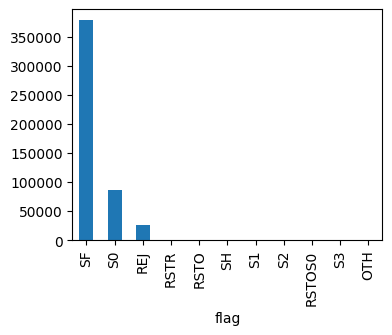

In [42]:
plt.figure(figsize=(4,3))
bar_graph(kdd_df, 'flag')

In [43]:
# protocol_type feature mapping
pmap = {'icmp': 0, 'tcp': 1, 'udp': 2}
kdd_df['protocol_type'] = kdd_df['protocol_type'].map(pmap)

In [44]:
# flag mapping
fmap = {'SF': 0, 'S0': 1, 'REJ':2, 'RSTR': 3, 'RSTO': 4, 'SH': 5 ,'S1': 6 , 'S2': 7, 'RSTOS0': 8, 'S3': 9 , 'OTH': 10}
kdd_df['flag'] = kdd_df['flag'].map(fmap)

remove redundant data (high correlation) to simplify the model without losing significant information.

high correlation (in this context) means that two columns are very similar in terms of their data values.

In [45]:
high_corr_threshold = 0.97

filtered_cols = [col for col in num_cols if col not in ['service', 'protocol_type', 'flag']]

corr_matrix = kdd_df[filtered_cols].corr()
high_corr_pairs = []

for col in corr_matrix.columns:
    related_cols = corr_matrix[col][abs(corr_matrix[col]) > high_corr_threshold].index.tolist()
    if len(related_cols) > 1:
        high_corr_pairs.append((col, related_cols))

keep_columns = set()
drop_columns = set()

grouped_columns = {}
for col, related_cols in high_corr_pairs:
    group = set([col] + related_cols)
    group_key = frozenset(group) # Avoid duplicates by using a frozenset
    if group_key not in grouped_columns:
        grouped_columns[group_key] = list(group)

for group_key, columns in grouped_columns.items():
    columns.sort()
    representative = columns[0]  # Choose the first column as representative
    keep_columns.add(representative)
    for col in columns[1:]:
        drop_columns.add(col)

group_number = 1
for group_key, columns in grouped_columns.items():
    representative = columns[0]
    print(f"Group {group_number} ({representative}-related):")
    print(f"Columns: {', '.join(columns)}")
    print(f"Drop: {', '.join(columns[1:])}")
    print(f"Keep: {representative} (as a representative)\n")
    group_number += 1


Group 1 (num_compromised-related):
Columns: num_compromised, num_root
Drop: num_root
Keep: num_compromised (as a representative)

Group 2 (dst_host_serror_rate-related):
Columns: dst_host_serror_rate, dst_host_srv_serror_rate, serror_rate, srv_serror_rate
Drop: dst_host_srv_serror_rate, serror_rate, srv_serror_rate
Keep: dst_host_serror_rate (as a representative)

Group 3 (dst_host_rerror_rate-related):
Columns: dst_host_rerror_rate, dst_host_srv_rerror_rate, rerror_rate, srv_rerror_rate
Drop: dst_host_srv_rerror_rate, rerror_rate, srv_rerror_rate
Keep: dst_host_rerror_rate (as a representative)

Group 4 (dst_host_same_srv_rate-related):
Columns: dst_host_same_srv_rate, dst_host_srv_count
Drop: dst_host_srv_count
Keep: dst_host_same_srv_rate (as a representative)



In [46]:
kdd_df.shape

(494020, 43)

In [47]:
kdd_df.drop(['num_root'],axis = 1,inplace = True)
kdd_df.drop(['dst_host_srv_serror_rate', 'serror_rate', 'srv_serror_rate'],axis = 1,inplace = True)
kdd_df.drop(['dst_host_srv_rerror_rate', 'rerror_rate', 'srv_rerror_rate'],axis = 1,inplace = True)
kdd_df.drop(['dst_host_srv_count'],axis = 1,inplace = True)

In [48]:
kdd_df.shape

(494020, 35)

In [49]:
kdd_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,srv_diff_host_rate,dst_host_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,target,attack_type
0,0,1,http,0,239,486,0,0,0,0,...,0.0,19,1.0,0.0,0.05,0.0,0.0,0.0,normal.,normal
1,0,1,http,0,235,1337,0,0,0,0,...,0.0,29,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
2,0,1,http,0,219,1337,0,0,0,0,...,0.0,39,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
3,0,1,http,0,217,2032,0,0,0,0,...,0.0,49,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal
4,0,1,http,0,217,2032,0,0,0,0,...,0.0,59,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal


drop target out as we aim to classify the types of atttack

In [50]:
kdd_df['target'].value_counts()

,count
target,
smurf.,280790
neptune.,107201
normal.,97277
back.,2203
satan.,1589
ipsweep.,1247
portsweep.,1040
warezclient.,1020
teardrop.,979


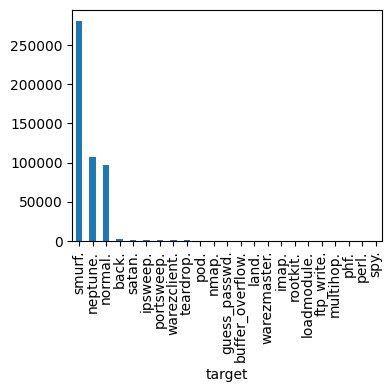

In [51]:
plt.figure(figsize=(4, 3))
bar_graph(kdd_df, 'target')

In [52]:
kdd_df['attack_type'].value_counts()

,count
attack_type,
dos,391458
normal,97277
probe,4107
r2l,1126
u2r,52


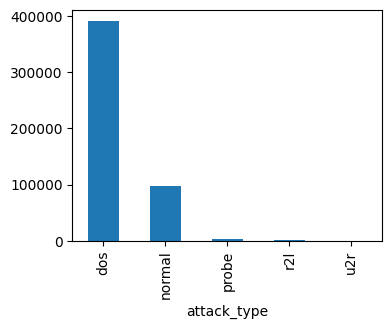

In [53]:
plt.figure(figsize=(4, 3))
bar_graph(kdd_df, 'attack_type')

In [54]:
kdd_df['service'].value_counts()

,count
service,
ecr_i,281400
private,110893
http,64292
smtp,9723
other,7237
...,...
X11,11
tim_i,7
pm_dump,1


In [55]:
kdd_df.drop('service', axis = 1, inplace= True)

In [56]:
kdd_df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,srv_diff_host_rate,dst_host_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,target,attack_type
0,0,1,0,239,486,0,0,0,0,0,...,0.0,19,1.0,0.0,0.05,0.0,0.0,0.0,normal.,normal
1,0,1,0,235,1337,0,0,0,0,0,...,0.0,29,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
2,0,1,0,219,1337,0,0,0,0,0,...,0.0,39,1.0,0.0,0.03,0.0,0.0,0.0,normal.,normal
3,0,1,0,217,2032,0,0,0,0,0,...,0.0,49,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal
4,0,1,0,217,2032,0,0,0,0,0,...,0.0,59,1.0,0.0,0.02,0.0,0.0,0.0,normal.,normal


In [57]:
len(kdd_df.columns)

34

# Scaling

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [59]:
kdd_df = kdd_df.drop(['target'], axis=1)

In [60]:
X = kdd_df.drop(['attack_type',], axis=1)
Y = kdd_df[['attack_type']]

In [61]:
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=1166)

In [63]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(345814, 32) (148206, 32)
(345814, 1) (148206, 1)


# GaussainNB

In [64]:
from sklearn.naive_bayes import GaussianNB

# Logistic Regression

# KerasClassifier